# Emittance Sample study


# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thin_lens = False
use_bmag = True
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 10 #number of random initial observations for GP model
n_samples = 3 #number of posterior samples for BAX
n_iter = 20 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
energy = CONFIG['beamline_info']['energy']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

def measure_beamsize(input_dict):
    scale = 1.e4
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key != str(meas_param):
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.+50,
            'yrms_sq': (float(yrms)*scale)**2.+50} # mean-square beam sizes in mm squared

# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]]


In [8]:
from lcls_tools.common.measurements.emittance_measurement import compute_emit_bmag_quad_scan
from lcls_tools.common.data.model_general_calcs import bdes_to_kmod
def eval_true_emittance(x, use_bmag=False):
    emits = []
    bmags = []
    q = torch.linspace(-3,3,11)
    k = bdes_to_kmod(energy, q_len, q)
    k = torch.stack((k,-k))
    rmat = torch.stack((rmat_x, rmat_y))
    twiss0_x = torch.tensor([10, -1])
    twiss0_y = torch.tensor([11, -2])
    twiss0 = torch.cat((twiss0_x.reshape(1, 2),
                       twiss0_y.reshape(1, 2))
                      )    
    for setting in x:
        bssx = []
        bssy = []
        input_dict = {name: float(setting[i]) for i, name in enumerate(vocs.variable_names)}
        for v in q.numpy():
            input_dict[meas_param] = v
            output_dict = measure_beamsize(input_dict)
            bssx += [output_dict['xrms_sq']]
            bssy += [output_dict['yrms_sq']]
        bss = torch.tensor([bssx, bssy])

        # compute emittance
        rv = compute_emit_bmag_quad_scan(k.numpy(), 
                                      bss.detach().numpy(), 
                                      q_len, 
                                      rmat.numpy(), 
                                      twiss0.numpy(),
                                      thin_lens=thin_lens,
                                      maxiter=100)

        emit = torch.from_numpy(rv['emittance'])
        bmag = torch.from_numpy(rv['bmag'])
        emits += [torch.sqrt(emit[0,0]*emit[1,0])]
        bmags += [torch.sqrt(bmag[0].min()*bmag[1].min())]
    res = torch.tensor(emits)
    if use_bmag:
        res *= torch.tensor(bmags)
    return res
eval_true_emittance(torch.zeros(1,ndim), use_bmag=use_bmag)

tensor([27.2505])

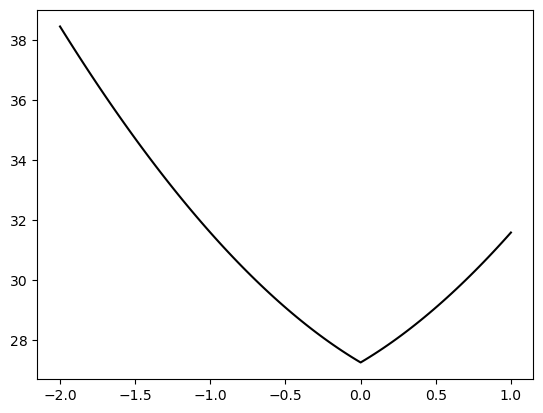

In [9]:
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
plt.plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')

# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [10]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [11]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=10,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [12]:
from bax_algorithms.emittance import PathwiseMinimizeEmittance
from bax_algorithms.pathwise.optimize import DifferentialEvolution

#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'energy': energy,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 3,
        'use_bmag': use_bmag,
        'observable_names_ordered': ['xrms_sq','yrms_sq'],
        'optimizer': DifferentialEvolution(minimize=True, maxiter=10, verbose=True),
        # 'maxiter_fit': 10,
}
algo = PathwiseMinimizeEmittance(**algo_kwargs)
# algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

generator.gp_constructor.use_low_noise_prior = True
#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [13]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
X.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,2.820743,72.787116,633.460510,0.001669,False
1,-1.124443,0.259001,81.061884,224.509325,0.001149,False
2,0.127286,-0.894864,82.956814,58.561415,0.000245,False
3,-0.532483,1.329076,50.945344,270.147451,0.000227,False
4,-1.678841,-1.057529,262.872091,81.911586,0.000221,False
5,-1.688879,-0.545177,185.931997,147.518189,0.000218,False
6,0.623244,2.856109,73.093442,622.219047,0.000218,False
7,0.378271,-0.353125,79.236712,84.702181,0.000218,False
8,0.845598,1.444485,51.105035,394.691586,0.000232,False
9,-0.322430,0.509393,57.732465,136.235879,0.000227,False


Beginning BAX virtual optimization.
BAX virtual optimization took: 1.4211971759796143 seconds.
Beginning BAX virtual optimization.
BAX virtual optimization took: 1.4392437934875488 seconds.


(<Figure size 600x400 with 2 Axes>,
 array([[<Axes: ylabel='xrms_sq'>],
        [<Axes: xlabel='x1', ylabel='yrms_sq'>]], dtype=object))

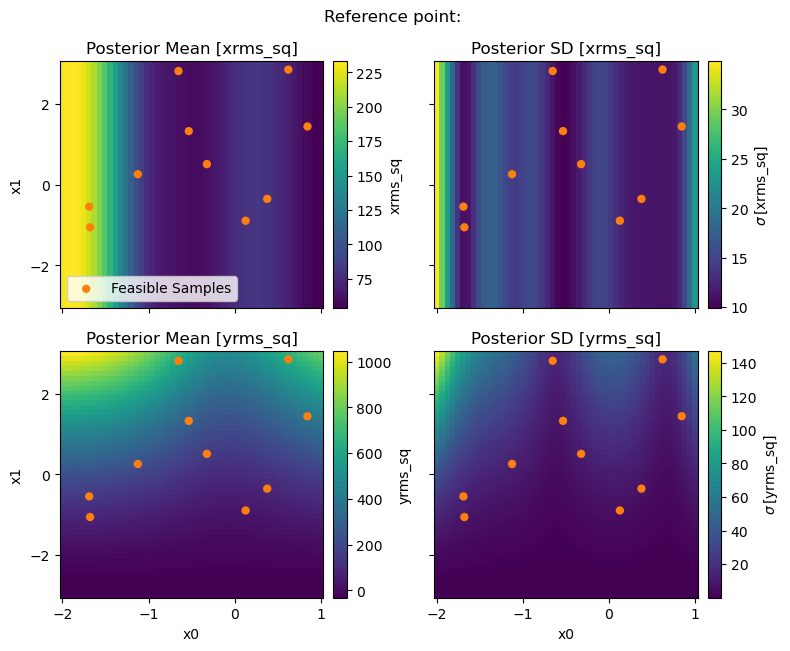

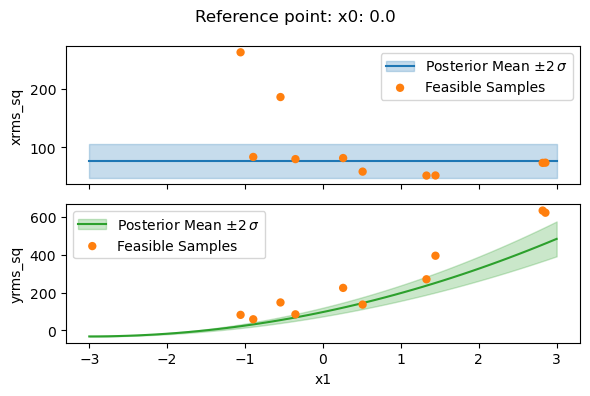

In [14]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
visualize_generator_model(X.generator, 
                          variable_names=['x0','x1'], 
                            reference_point={'x0':0.,
                                             'x1':0.,
                                            'x2':0.,
                                             'x3':0.,
                                             'x4':0.,
                                             'x5':0.,
                                             'x6':0.,
                             
                                             'x7':0.,
                                             'x8':0.,
                                            },
                          show_acquisition=False)
visualize_generator_model(X.generator, 
                          variable_names=['x1'], 
                            reference_point={'x0':0.,
                                             'x1':0.,
                                            'x2':0.,
                                             'x3':0.,
                                             'x4':0.,
                                             'x5':0.,
                                             'x6':0.,
                                             'x7':0.,
                                             'x8':0.,
                                            },
                          show_acquisition=False)

In [15]:
X.generator.algorithm.results['best_inputs']

tensor([[[-0.4276]],

        [[-0.0736]],

        [[-0.2156]]])

8.482972621917725


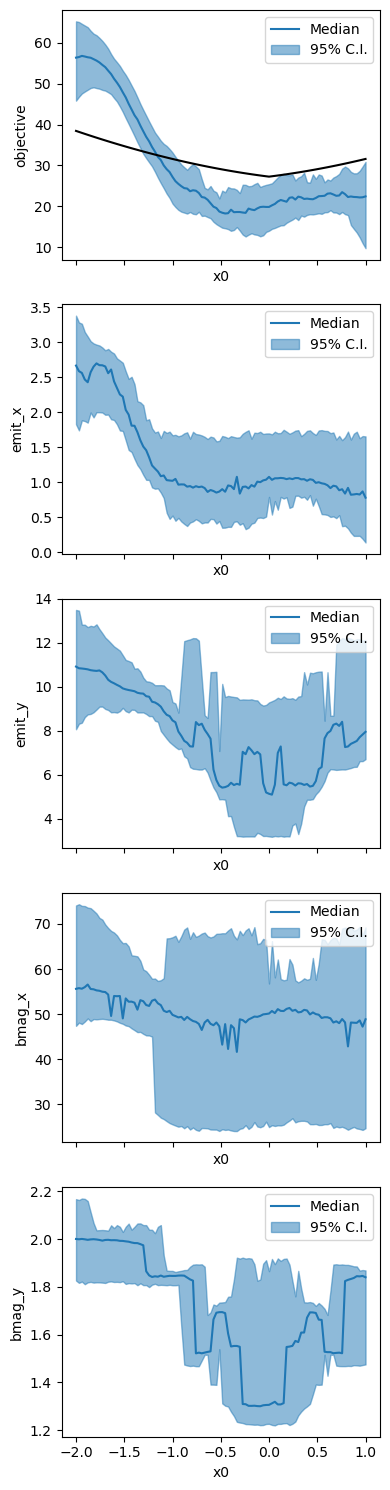

In [16]:
from bax_algorithms.visualize import visualize_virtual_measurement_result

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]),
                                             'x1':torch.tensor([0.]),
                                            # 'x2':torch.tensor([0.]),
                                            #  'x3':torch.tensor([0.]),
                                            #  'x4':torch.tensor([0.]),
                                             # 'x5':torch.tensor([0.]),
                                             # 'x6':torch.tensor([0.]),
                                             # 'x7':torch.tensor([0.]),
                                             # 'x8':torch.tensor([0.]),
                                            },
                            n_grid=100,
                            n_samples=100,
                            result_keys=['objective','emit_x','emit_y','bmag_x','bmag_y'],
                            # show_samples=True,
                                     )
print(time.time()-start)
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
ax[0].plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')
# plt.ylim(top=0.01)

In [17]:
from bax_algorithms.utils import get_bax_mean_prediction, tuning_input_tensor_to_dict
mean_optimizer = DifferentialEvolution(minimize=True, popsize=100, maxiter=100, verbose=True)
x_tuning = get_bax_mean_prediction(X.generator, mean_optimizer)
x_tuning_dict = tuning_input_tensor_to_dict(X.generator, x_tuning)
print(x_tuning)
print(x_tuning_dict)

Beginning BAX virtual optimization.
BAX virtual optimization took: 13.129581451416016 seconds.
tensor([[0.1804]])
{'x0': 0.18038777691077923}


In [18]:
for i in range(n_iter):
    print(i)
    start = time.time()
    X.step()
    print(time.time() - start)

0
Beginning BAX virtual optimization.
BAX virtual optimization took: 1.5731241703033447 seconds.
7.958345174789429
1
Beginning BAX virtual optimization.
BAX virtual optimization took: 1.505317211151123 seconds.
9.917348146438599
2
Beginning BAX virtual optimization.
BAX virtual optimization took: 1.4062023162841797 seconds.
9.090873718261719
3
Beginning BAX virtual optimization.
BAX virtual optimization took: 0.44913601875305176 seconds.
3.843015670776367
4
Beginning BAX virtual optimization.
BAX virtual optimization took: 0.516075849533081 seconds.
3.5919792652130127
5
Beginning BAX virtual optimization.
BAX virtual optimization took: 1.4380857944488525 seconds.
4.195128440856934
6
Beginning BAX virtual optimization.
BAX virtual optimization took: 0.48566508293151855 seconds.
3.0190176963806152
7
Beginning BAX virtual optimization.
BAX virtual optimization took: 0.4153633117675781 seconds.
2.916989326477051
8
Beginning BAX virtual optimization.
BAX virtual optimization took: 0.4475126

In [19]:
start = time.time()
X.generator.train_model()
print(time.time()-start)

1.0823934078216553


1.842560052871704


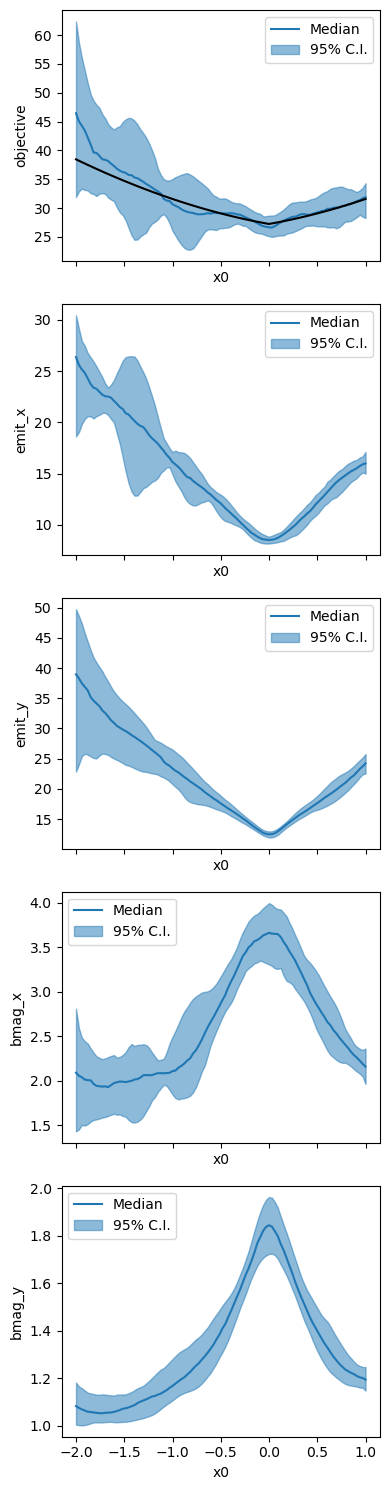

In [20]:
from bax_algorithms.visualize import visualize_virtual_measurement_result

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]),
                                             'x1':torch.tensor([0.]),
                                            # 'x2':torch.tensor([0.]),
                                            #  'x3':torch.tensor([0.]),
                                            #  'x4':torch.tensor([0.]),
                                             # 'x5':torch.tensor([0.]),
                                             # 'x6':torch.tensor([0.]),
                                             # 'x7':torch.tensor([0.]),
                                             # 'x8':torch.tensor([0.]),
                                            },
                            n_grid=100,
                            n_samples=100,
                            result_keys=['objective','emit_x','emit_y','bmag_x','bmag_y'],
                            # show_samples=True,
                                     )
print(time.time()-start)
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
ax[0].plot(x[:,0], eval_true_emittance(x, use_bmag=use_bmag), c='k')
# plt.ylim(top=0.01)

In [21]:
x_tuning = get_bax_mean_prediction(X.generator, mean_optimizer)
x_tuning_dict = tuning_input_tensor_to_dict(X.generator, x_tuning)
print(x_tuning)
print(x_tuning_dict)

Beginning BAX virtual optimization.
BAX virtual optimization took: 0.3659546375274658 seconds.
tensor([[-0.0044]])
{'x0': -0.0043781020237836366}


In [22]:
from bax_algorithms.utils import uniform_random_sample_in_bounds
from bax_algorithms.utils import get_bax_model_and_bounds
bax_model, bounds = get_bax_model_and_bounds(X.generator)
x0 = uniform_random_sample_in_bounds(3000, bounds)
start = time.time()
algo.evaluate_virtual_objective(X.generator.algorithm.results['sample_functions_list'], x0.reshape(n_samples, 1000, -1), bounds)
print(time.time()-start)

0.39964938163757324


In [23]:
reference_point={'x0':torch.tensor([0.]),
                 'x1':torch.tensor([0.]),
                # 'x2':torch.tensor([0.]),
                #  'x3':torch.tensor([0.]),
                #  'x4':torch.tensor([0.]),
                 # 'x5':torch.tensor([0.]),
                 # 'x6':torch.tensor([0.]),
                 # 'x7':torch.tensor([0.]),
                 # 'x8':torch.tensor([0.]),
                },
fig, ax, best_q = plot_virtual_measurement_scan(X, reference_point, n_samples=10)
ax[0].set_ylim(top=1)
ax[1].set_ylim(top=3, bottom=0.9)
ax[0].axhline(0, c='k')

NameError: name 'plot_virtual_measurement_scan' is not defined